In [12]:
import pandas as pd
import numpy as np
import datetime
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from math import sqrt, floor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

## Load Data

In [13]:
df = pd.read_csv("Year 2009-2010.csv", encoding="ISO-8859-1")

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom


In [14]:
#df['Quant*Price'] = df.apply(lambda row: row['Quantity']*row['Price'], axis = 1)
df['Quant*Price'] = df['Quantity'].multiply(df['Price'])
summed = df.groupby(['Invoice', 'Customer ID', 'Country', 'InvoiceDate']).agg('sum').reset_index()
summed = summed.set_index('InvoiceDate')
summed = summed.drop(columns=["Quantity", "Price"])

print(df.shape)
print(summed.shape)
summed.head()

(525461, 9)
(23622, 4)


,Invoice,Customer ID,Country,Quant*Price
InvoiceDate,,,,
12/1/2009 7:45,489434,13085.0,United Kingdom,505.30
12/1/2009 7:46,489435,13085.0,United Kingdom,145.80
12/1/2009 9:06,489436,13078.0,United Kingdom,630.33
12/1/2009 9:08,489437,15362.0,United Kingdom,310.75
12/1/2009 9:24,489438,18102.0,United Kingdom,2286.24


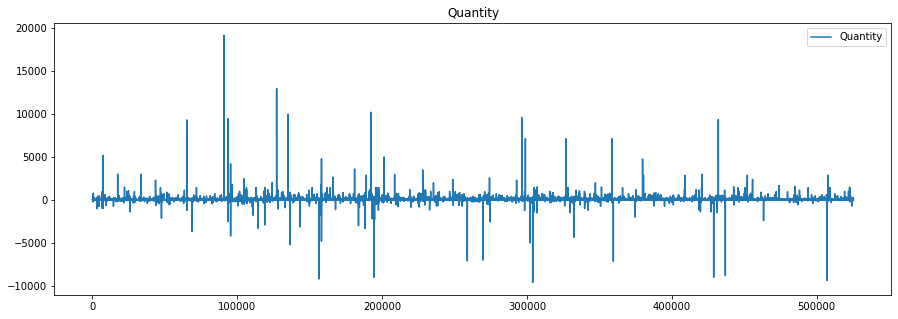

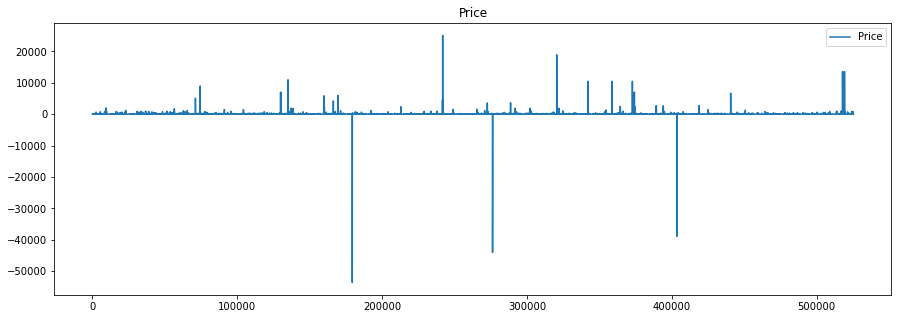

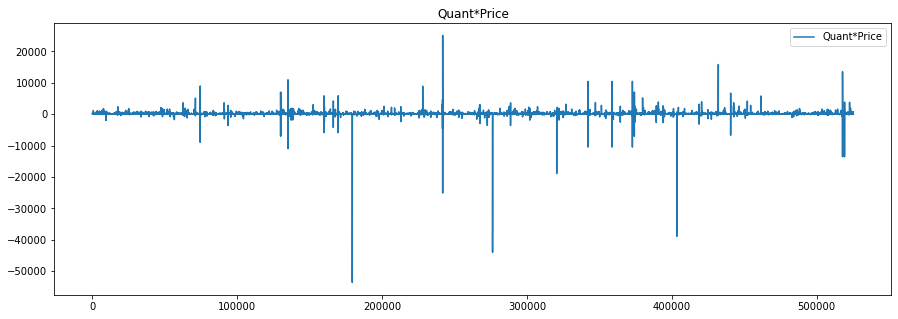

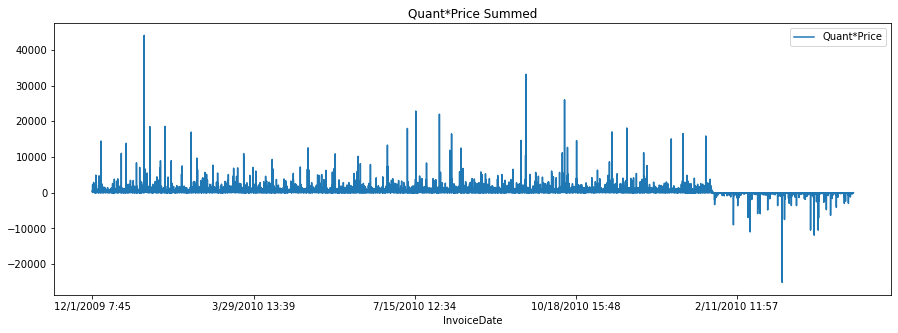

In [15]:
df.plot(y="Quantity", figsize=(15,5)).set_title('Quantity')
df.plot(y="Price", figsize=(15,5)).set_title('Price')
df.plot(y="Quant*Price", figsize=(15,5)).set_title('Quant*Price')
summed.plot(y="Quant*Price", figsize=(15,5)).set_title('Quant*Price Summed')

pyplot.show()

# LSTM Application

## Function For Converting Time Series Data for Supervised Learning

In [16]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    summed = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(summed.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(summed.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Preparing Data

In [17]:
values = summed.values

In [18]:
# integer encoding of labels (not using yet here)
encoder = LabelEncoder()
values[:,2] = encoder.fit_transform(values[:,2])
values[:,0] = encoder.fit_transform(values[:,0])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Drop Columns of Variables We Aren't Predicting
reframed.drop(reframed.columns[[4, 5, 6]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
1,0.000000,0.124390,0.944444,0.370379,0.365181
2,0.000042,0.124390,0.944444,0.365181,0.372187
3,0.000085,0.123211,0.944444,0.372187,0.367566
4,0.000127,0.507658,0.944444,0.367566,0.396129
5,0.000170,0.968860,0.944444,0.396129,0.369236


In [19]:
# split into train and test sets
values = reframed.values
n_train = floor(len(values) * 0.2)
n_predict = 90
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :]
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(4724, 1, 4) (4724,) (18807, 1, 4) (18807,) (90, 1, 4) (90,)


Epoch 1/50
64/64 - 1s - loss: 0.1491 - val_loss: 0.0327
Epoch 2/50
64/64 - 0s - loss: 0.0197 - val_loss: 0.0256
Epoch 3/50
64/64 - 0s - loss: 0.0119 - val_loss: 0.0247
Epoch 4/50
64/64 - 0s - loss: 0.0113 - val_loss: 0.0251
Epoch 5/50
64/64 - 0s - loss: 0.0107 - val_loss: 0.0256
Epoch 6/50
64/64 - 0s - loss: 0.0101 - val_loss: 0.0263
Epoch 7/50
64/64 - 0s - loss: 0.0094 - val_loss: 0.0268
Epoch 8/50
64/64 - 0s - loss: 0.0086 - val_loss: 0.0287
Epoch 9/50
64/64 - 0s - loss: 0.0079 - val_loss: 0.0303
Epoch 10/50
64/64 - 0s - loss: 0.0072 - val_loss: 0.0326
Epoch 11/50
64/64 - 0s - loss: 0.0065 - val_loss: 0.0325
Epoch 12/50
64/64 - 0s - loss: 0.0064 - val_loss: 0.0294
Epoch 13/50
64/64 - 0s - loss: 0.0063 - val_loss: 0.0262
Epoch 14/50
64/64 - 0s - loss: 0.0059 - val_loss: 0.0217
Epoch 15/50
64/64 - 0s - loss: 0.0058 - val_loss: 0.0194
Epoch 16/50
64/64 - 0s - loss: 0.0057 - val_loss: 0.0174
Epoch 17/50
64/64 - 0s - loss: 0.0057 - val_loss: 0.0159
Epoch 18/50
64/64 - 0s - loss: 0.0056 - 

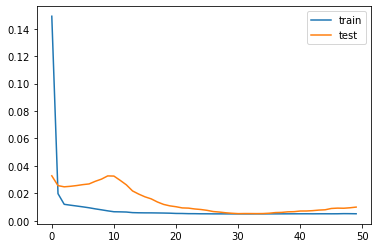

In [20]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=74, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [21]:
# make a prediction
yhat = model.predict(predict_X)
predict_X = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [22]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 435.664
Normalized RMSE: 0.633


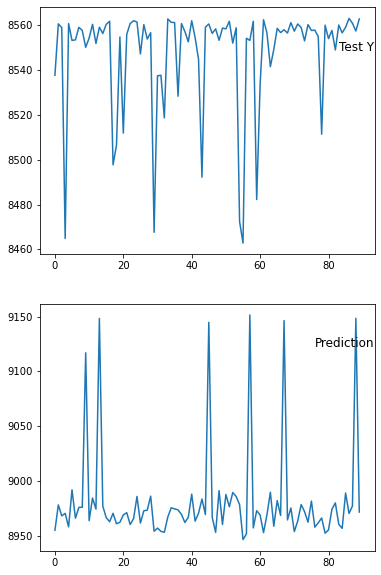

In [23]:
pyplot.figure(figsize=(6,10))
pyplot.subplot(2, 1, 1)
pyplot.plot(inv_y, label="Test Y")
pyplot.title("Test Y", y=0.8, loc='right')
pyplot.subplot(2, 1, 2)
pyplot.plot(inv_yhat, label="Prediction")
pyplot.title("Prediction", y=0.8, loc='right')
pyplot.show()